# Import the necessary packages and helper functions

In [3]:
import sdc_jax as sdc 
import os
import matplotlib.pyplot as plt
import yaml
import numpy as np

def adjust_indices(indices, factor):
    top, bottom, left, right = indices
    
    # Ensure indices are divisible by the downsample factor
    if top % factor != 0:
        top -= factor - (top % factor)
    if bottom % factor != 0:
        bottom += bottom % factor
    if left % factor != 0:
        left -= factor - (left % factor)
    if right % factor != 0:
        right += right % factor
    
    # Ensure the height and width are even after downsampling
    height = bottom - top
    width = right - left
    
    if (height // factor) % 2 != 0:
        bottom += factor  # Adjust to make the height even
    if (width // factor) % 2 != 0:
        right += factor  # Adjust to make the width even
    
    return [top, bottom, left, right]

# Define all of your parameters

In [8]:
# Define the paths to the calibration files
calibration_folder_location = "/home/neerja/CODE/SpectralDiffuserScopeGitRepo/PlottingCode/Calibration_data"

# Provide the name of the calibration files to be used
psf_name = "psf_2023-07-26.pt"
calibration_wavelengths_file = "wavelengths_2024-02-28.npy"
filter_cube_file = "spectral_filter_2024-02-28.npy"

# Define the path to the data file
datafolder = '/media/azuldata/neerja/2023-08-01/Samples/USAF_0'
sample = datafolder.split("/")[-1] 

# Define some parameters for measurement processing
bits = 16
crop_indices = [800,1600,1400,2400] # [top, bottom, left, right]
wvmin = 450
wvmax = 700
wvstep = 8
downsample_factor = 2

# Adjust crop indices to make sure they are divisible by downsample factor and even after downsampling
crop_indices = adjust_indices(crop_indices, downsample_factor)

# Define some reconstruction parameters
kmax = 1000
step_size = 0.1
thr = 6e-5
xytv = 1e-5
lamtv = 2e-5 
use_low_rank = True
use_one_hot = True
rank = 3 # number of components expected in image

# Define some WandB parameters
kprint = 100
project_name = "HyperSpectralDiffuserScope"
run_name = "usaf0"
# run_name = sample + '_thr={}_xytv={}_lamtv={}_kmax={}_stepsize={}_downsample={}'.format(thr, xytv, lamtv, kmax, step_size, downsample_factor)
save_location = '/home/neerja/CODE/SpectralDiffuserScopeGitRepo/PlottingCode/Results/Testing'
save_frequency = 100 

# config_file_path = "./Config_Files/config_"+sample+".yaml"
config_file_path = "./Config_Files/usaf0.yaml"


# Make sure you have selected the correct ROI

IntProgress(value=0, max=5)

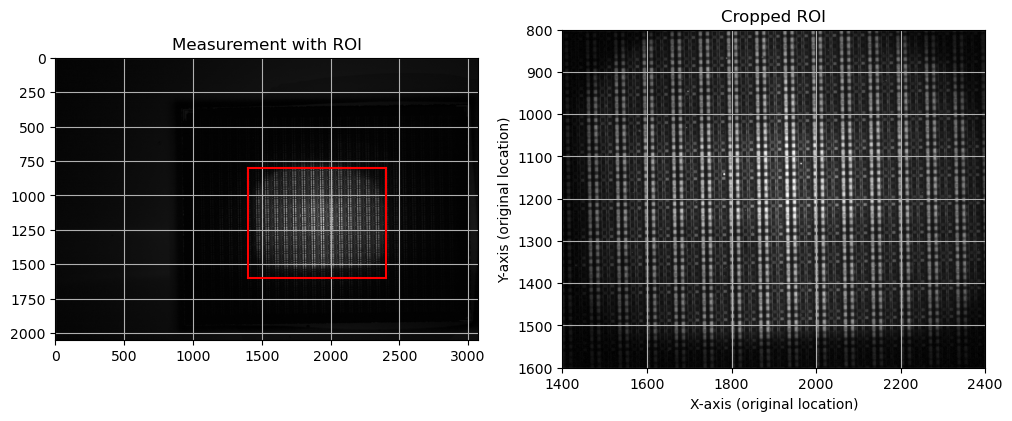

In [9]:
# Load the measurement
try:
    sample_meas = sdc.importTiff(datafolder,'meas.tiff')/(2**bits-1)
except:
    sample_meas = np.mean(sdc.tif_loader(os.path.join(datafolder,'measurements'))/(2**bits-1),0)
try:
    background = sdc.importTiff(datafolder,'bg.tiff')/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = np.zeros(sample_meas.shape)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

meas = sample_meas - background
#set negative values to 0
meas[meas<0] = 0
# First subplot: Measurement with ROI outlined
ax[0].imshow(meas**.5, cmap='gray')
ax[0].plot([crop_indices[2], crop_indices[3]], [crop_indices[0], crop_indices[0]], 'r')
ax[0].plot([crop_indices[2], crop_indices[3]], [crop_indices[1], crop_indices[1]], 'r')
ax[0].plot([crop_indices[2], crop_indices[2]], [crop_indices[0], crop_indices[1]], 'r')
ax[0].plot([crop_indices[3], crop_indices[3]], [crop_indices[0], crop_indices[1]], 'r')
ax[0].set_title('Measurement with ROI')
ax[0].grid()

# Second subplot: ROI with original axis labels
roi = meas[crop_indices[0]:crop_indices[1], crop_indices[2]:crop_indices[3]]
ax[1].imshow(roi**.5, cmap='gray', extent=[crop_indices[2], crop_indices[3], crop_indices[1], crop_indices[0]])
ax[1].set_title('Cropped ROI')
ax[1].set_xlabel('X-axis (original location)')
ax[1].set_ylabel('Y-axis (original location)')
ax[1].grid()

# Show the figure
plt.show()

# Save everything as a config file

In [10]:
config = {
    "calibration": {
        "folder_location": calibration_folder_location,
        "psf_name": psf_name,
        "calibration_wavelengths_file": calibration_wavelengths_file,
        "filter_cube_file": filter_cube_file
    },
    "data": {
        "datafolder": datafolder,
        "sample": sample
    },
    "measurement_processing": {
        "bits": bits,
        "crop_indices": crop_indices,
        "wvmin": wvmin,
        "wvmax": wvmax,
        "wvstep": wvstep,
        "downsample_factor": downsample_factor
    },
    "reconstruction": {
        "kmax": kmax,
        "step_size": step_size,
        "thr": thr,
        "xytv": xytv,
        "lamtv": lamtv,
        "use_low_rank": use_low_rank,
        "use_one_hot": use_one_hot,
        "rank": rank
    },
    "wandb": {
        "kprint": kprint,
        "project_name": project_name,
        "run_name": run_name,
        "save_location": save_location,
        "save_frequency": save_frequency
    }
}

# Save the configuration to a YAML file
with open(config_file_path, 'w') as config_file:
    yaml.dump(config, config_file, default_flow_style=False)

print(f"Configuration saved to {config_file_path}")

Configuration saved to ./Config_Files/usaf0.yaml
